In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from cleantext import clean
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import swifter
import operator
import xgboost as xgb

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [ ]:
end_result = pd.read_csv('news_cleaned_2018_02_13.csv', encoding='utf8', nrows=1_600_000, dtype={'content':'string', 'type':'string'}, usecols=['content', 'type'], lineterminator='\n', skip_blank_lines=True)

end_result.dropna(subset=['content'])
print("Content without empty content:", len(end_result.index))

end_result = end_result[~end_result['type'].isin(['nan', 'unknown'])]
print("Content without Nan and unknown types:", len(end_result.index))

end_result = end_result.drop_duplicates(subset=['content'])
print("Content without duplicate contents:", len(end_result.index))

end_result.to_csv('content_type_data.csv', columns=['content', 'type'])

Content without empty content:  1600000
Content without Nan and unknown types:  1546834
Content without duplicate contents:  1077683


In [2]:
def clean_data(input_text):
    cleaned_text = re.sub(r'(\S+\.com*\S+)', '<url>', input_text)
    cleaned_text = re.sub(r'(\S+\.net*\S+)', '<url>', cleaned_text)
    cleaned_text = re.sub(r'\-', ' ', cleaned_text)
    cleaned_text = re.sub(r'\|', ' ', cleaned_text)
    cleaned_text = clean(cleaned_text,  # does not remove special characters such as < , ^ etc.
        normalize_whitespace=True,
        fix_unicode=True,  # fix various unicode errors
        to_ascii=True,  # transliterate to closest ASCII representation
        lower=True,  # lowercase text
        no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
        no_urls=True,  # replace all URLs with a special token
        no_emails=True,  # replace all email addresses with a special token
        no_phone_numbers=True,  # replace all phone numbers with a special token
        no_numbers=True,  # replace all numbers with a special token
        no_digits=True,  # replace all digits with a special token
        no_currency_symbols=True,  # replace all currency symbols with a special token
        no_punct=True,  # remove punctuations
        no_emoji=True,
        replace_with_punct="",  # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="<NUMBER>",
        replace_with_digit="<DIGIT>",
        replace_with_currency_symbol="<CUR>",
        lang="en")

    return cleaned_text

In [3]:
#uses 5-6 gb of ram slow 2h
df = pd.read_csv('content_type_data.csv', encoding='utf8', dtype={'content':'string', 'type':'string'})
data_size = len(df.index)
pd.DataFrame(columns=['content', 'type']).to_csv("cleaned_text.csv")

for i in range(0,data_size):
    content_result = clean_data(df.iloc[i]['content'])
    type_result = df.iloc[i]['type']

    result = {'content':content_result, 'type':type_result}
    new_data = pd.DataFrame(result, index=[i])
    new_data.to_csv('cleaned_text.csv', mode='a', header=False)

In [4]:
df_cleaned = pd.read_csv('cleaned_text.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}).dropna(subset=['content'])
df_cleaned['type'] = df_cleaned['type'].replace(['unreliable', 'bias', 'junksci', 'conspiracy', 'hate', 'rumor', 'satire', 'state'], 'fake')
df_cleaned['type'] = df_cleaned['type'].replace(['political', 'clickbait'], 'reliable')
df_cleaned.columns = df_cleaned.columns.str.strip() #Remove unecessary \r
df_cleaned['type'] = df_cleaned['type'].replace('\r', '', regex=True) #Remove unecessary r from types
df_cleaned.to_csv('cleaned_changed_types.csv', columns=['content', 'type'])

In [2]:
def remove_placeholder_words(input_text):
    cleaned_text = re.sub(r'\<\w+\>', ' ', input_text)
    cleaned_text = re.sub(' +', ' ', cleaned_text)

    return cleaned_text

In [5]:
#runs 1gb of data in ca 30 min
df = pd.read_csv('cleaned_changed_types.csv', encoding='utf8', dtype={'content':'string', 'type':'string'})
data_size = len(df.index)
pd.DataFrame(columns=['content', 'type']).to_csv("cleaned_removed_placeholder.csv")

for i in range(0,data_size):
    content_result = remove_placeholder_words(df.iloc[i]['content'])
    type_result = df.iloc[i]['type']

    result = {'content':content_result, 'type':type_result}
    new_data = pd.DataFrame(result, index=[i])
    new_data.to_csv('cleaned_removed_placeholder.csv', mode='a', header=False)

In [ ]:
df = pd.read_csv('cleaned_removed_placeholder.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}).dropna(subset=['content'])
df.to_csv('cleaned_removed_placeholder.csv', columns=['content', 'type'])

In [2]:
def remove_stop_words(input_text):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = []
    cleaned_text = word_tokenize(input_text)

    for w in cleaned_text:
        if w not in stop_words:
            filtered_sentence.append(w)

    return ' '.join(filtered_sentence)

In [5]:
#about 1h
df = pd.read_csv('cleaned_removed_placeholder.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}) #about as slow as clean text 1,5h
data_size = len(df.index)
pd.DataFrame(columns=['content', 'type']).to_csv("cleaned_removed_stop_words.csv")

for i in range(0,data_size):
    content_result = remove_stop_words(df.iloc[i]['content'])
    type_result = df.iloc[i]['type']

    result = {'content':content_result, 'type':type_result}
    new_data = pd.DataFrame(result, index=[i])
    new_data.to_csv('cleaned_removed_stop_words.csv', mode='a', header=False)

In [ ]:
df = pd.read_csv('cleaned_removed_stop_words.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}).dropna(subset=['content'])
df.to_csv('cleaned_removed_stop_words.csv', columns=['content', 'type'])

In [2]:
def stemming_words(input_text):
    ps = PorterStemmer()

    stemmed_words = []

    for word in word_tokenize(input_text):
        stemmed_words.append(ps.stem(word))

    return ' '.join(stemmed_words)

In [3]:
#heavy on memory and cpu usage 3h
df = pd.read_csv('cleaned_removed_stop_words.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}) #about as slow as clean text 1,5h
data_size = len(df.index)
pd.DataFrame(columns=['content', 'type']).to_csv("cleaned_stemmed.csv")

for i in range(0,data_size):
    content_result = stemming_words(df.iloc[i]['content'])
    type_result = df.iloc[i]['type']

    result = {'content':content_result, 'type':type_result}
    new_data = pd.DataFrame(result, index=[i])
    new_data.to_csv('cleaned_stemmed.csv', mode='a', header=False)

In [ ]:
df = pd.read_csv('cleaned_stemmed.csv', encoding='utf8', dtype={'content':'string', 'type':'string'}).dropna(subset=['content'])
df.to_csv('cleaned_stemmed.csv', columns=['content', 'type'])

In [4]:
df = pd.read_csv('cleaned_changed_types.csv', encoding='utf8', dtype={'content':'string', 'type':'string'})
data_size = len(df.index)

placeholder_counter = [['<url>', 0], ['<email>', 0], ['<phone>', 0], ['<number>', 0], ['<digit>', 0], ['<cur>', 0]]

for i in range(0, data_size):
    current_text = df.iloc[i]['content']
    for j in range(0, len(placeholder_counter)-1):
        placeholder_counter[j][1] += len(re.findall(placeholder_counter[j][0], current_text))

print(placeholder_counter)

[['<url>', 583598], ['<email>', 4876], ['<phone>', 133847], ['<number>', 11317022], ['<digit>', 2448658], ['<cur>', 0]]


In [2]:
def total_word_counter(input_text, text_size):
    total_counter = 0
    for i in range(0, text_size):
        total_counter += len(re.findall(' ', input_text.iloc[i]['content']))+1

    return total_counter

df = pd.read_csv('cleaned_changed_types.csv', encoding='utf8', dtype={'content': 'string', 'type': 'string'}, lineterminator='\n')
data_size = len(df.index)
print("Total number of words after cleaning:", total_word_counter(df, data_size))
df = pd.read_csv('cleaned_removed_placeholder.csv', encoding='utf8', dtype={'content': 'string', 'type': 'string'}, lineterminator='\n')
data_size = len(df.index)
print("Total number of words after removing placeholders:", total_word_counter(df, data_size))
df = pd.read_csv('cleaned_removed_stop_words.csv', encoding='utf8', dtype={'content': 'string', 'type': 'string'}, lineterminator='\n')
data_size = len(df.index)
print("Total number of words after removing stopwords:", total_word_counter(df, data_size))
df = pd.read_csv('cleaned_stemmed.csv', encoding='utf8', dtype={'content': 'string', 'type': 'string'}, lineterminator='\n')
data_size = len(df.index)
print("Total number of words after stemming:", total_word_counter(df, data_size))

Total number of words after cleaning: 568003786
Total number of words after removing placeholders: 557067402
Total number of words after removing stopwords: 319928342
Total number of words after stemming: 319928342


In [2]:
df = pd.read_csv('content_type_data.csv', encoding='utf8', dtype={'content':'string', 'type':'string'})
type_list = df['type'].value_counts(dropna=True)
print(type_list)

political     271131
rumor         138541
bias          136807
fake          120177
conspiracy    107712
hate           42968
unreliable     39067
satire         28572
clickbait      23724
junksci        17664
reliable        5887
Name: type, dtype: Int64


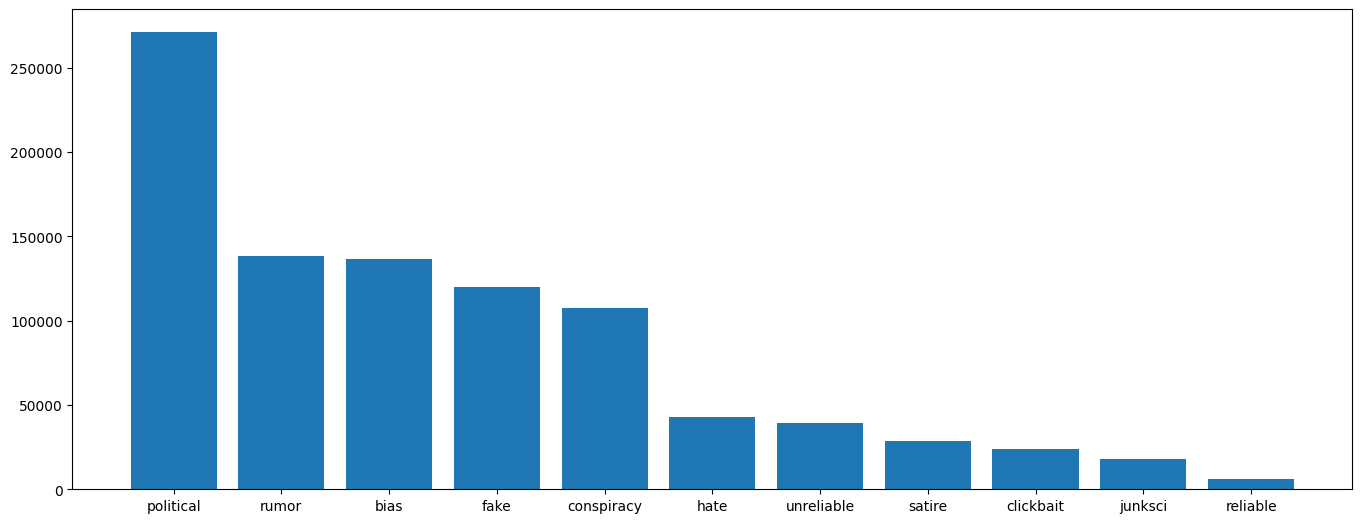

In [6]:
d = dict(type_list)

name_list = list(d.keys())
name_values = list(d.values())

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(list(name_list), list(name_values))
plt.show()


In [5]:
df = pd.read_csv('cleaned_stemmed.csv', encoding='utf8', dtype={'content':'string', 'type':'string'})
print(len(df.index))

1075189


In [3]:
#before stop and stem
data_size = 100000
df = pd.read_csv('cleaned_changed_types.csv', encoding='utf8', nrows=data_size, dtype={'content':'string', 'type':'string'})

counts = dict()
for i in range(0, data_size-1):
    words = word_tokenize(df.iloc[i]['content'])

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

sorted_list= sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_list[0:100])

[('the', 3620849), ('of', 1765584), ('to', 1747743), ('>', 1655530), ('<', 1648730), ('and', 1647538), ('a', 1293775), ('number', 1256726), ('in', 1177566), ('that', 809503), ('is', 777258), ('for', 599681), ('on', 480356), ('it', 444577), ('as', 402569), ('are', 399380), ('this', 393315), ('with', 390280), ('by', 328304), ('be', 327366), ('was', 323325), ('i', 314127), ('have', 294932), ('you', 291949), ('not', 291324), ('from', 275379), ('at', 263406), ('digit', 240903), ('he', 233062), ('they', 230941), ('we', 229491), ('but', 226207), ('has', 225617), ('or', 223807), ('an', 217466), ('his', 200019), ('will', 197488), ('their', 190004), ('all', 181030), ('its', 174714), ('who', 173780), ('more', 165041), ('about', 161656), ('us', 161195), ('one', 157972), ('can', 147928), ('if', 147790), ('what', 141692), ('were', 138496), ('so', 135376), ('our', 134629), ('which', 133456), ('would', 133415), ('been', 130153), ('people', 129191), ('your', 128260), ('out', 126080), ('trump', 125254),

In [2]:
#after stop and stem
data_size = 100000
df = pd.read_csv('cleaned_stemmed.csv', encoding='utf8', nrows=data_size, dtype={'content':'string', 'type':'string'})


counts = dict()
for i in range(0, data_size-1):
    words = word_tokenize(df.iloc[i]['content'])

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

sorted_list= sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_list[0:100])

[('one', 161742), ('us', 156382), ('trump', 144752), ('state', 144295), ('year', 129830), ('peopl', 129733), ('would', 128044), ('time', 125279), ('like', 115540), ('said', 110358), ('new', 105456), ('use', 98042), ('also', 96592), ('report', 91957), ('make', 87900), ('presid', 86329), ('get', 83634), ('american', 82077), ('blockchain', 79879), ('even', 79105), ('say', 78881), ('go', 78830), ('govern', 78781), ('two', 76646), ('right', 75805), ('nation', 70983), ('mani', 70949), ('world', 70801), ('day', 70366), ('work', 70096), ('first', 69124), ('think', 68333), ('next', 66444), ('could', 64730), ('take', 63794), ('may', 63319), ('obama', 62196), ('come', 62041), ('know', 61975), ('way', 61940), ('need', 61065), ('call', 61063), ('market', 60649), ('well', 60380), ('see', 59110), ('want', 57778), ('countri', 54915), ('includ', 54139), ('democrat', 53076), ('support', 52281), ('news', 51851), ('republican', 51565), ('fact', 51522), ('sourc', 51246), ('stock', 51149), ('polit', 51101),

In [4]:
df = pd.read_csv('news_cleaned_2018_02_13.csv', nrows=0, encoding='utf8')
print("headers: ", df.columns.values)
print("amount of headers: ", len(df.columns.values))

headers:  ['Unnamed: 0' 'id' 'domain' 'type' 'url' 'content' 'scraped_at'
 'inserted_at' 'updated_at' 'title' 'authors' 'keywords' 'meta_keywords'
 'meta_description' 'tags' 'summary' 'source']
amount of headers:  17


In [3]:
df = pd.read_csv('news_cleaned_2018_02_13.csv', nrows=1_600_000, encoding='utf8', dtype={'Unnamed: 0': 'string', 'id': 'string', 'domain': 'string', 'type': 'string', 'url': 'string', 'content': 'string', 'scraped_at': 'string', 'inserted_at': 'string', 'updated_at': 'string', 'title': 'string', 'authors': 'string', 'keywords': 'string', 'meta_keywords': 'string','meta_description': 'string', 'tags': 'string', 'summary': 'string', 'source': 'string',}, lineterminator='\n')

colum_names = df.columns.values
for i in range(0, len(colum_names)):
    nan_count = df[str(colum_names[i])].isna().sum()
    print("Number of NAN in colum " + str(colum_names[i]) + ":", nan_count)

Number of NAN in colum Unnamed: 0 : 0
Number of NAN in colum id : 0
Number of NAN in colum domain : 0
Number of NAN in colum type : 169748
Number of NAN in colum url : 0
Number of NAN in colum content : 0
Number of NAN in colum scraped_at : 0
Number of NAN in colum inserted_at : 0
Number of NAN in colum updated_at : 0
Number of NAN in colum title : 15678
Number of NAN in colum authors : 703210
Number of NAN in colum keywords : 1600000
Number of NAN in colum meta_keywords : 0
Number of NAN in colum meta_description : 948698
Number of NAN in colum tags : 963113
Number of NAN in colum summary : 1600000
Number of NAN in colum source : 1600000
